<center><h1> <span style="color:red">Classify Song Genres from Audio Data </span> </h1></center>

## Réaliser par : 
 <ul>
<li><i> Ibtissem BOUZIDI 3 DNI 2</i> </li>
<li> <i> Sabrine HOIYA 3 DNI 2 </i> </li>
    </ul>
    <center><img src="https://s3.amazonaws.com/assets.datacamp.com/production/project_449/img/iphone_music.jpg" alt="Project Image Record" width="200px"></center>

<center><h1> <span style="color:red">Problématique</span> </h1></center>
<center><img src="idee.png"  width="1000px"/></center>

<center><h1> <span style="color:red">Solution</span> </h1></center>
<center><img src="intro.png"  width="1000px"/></center>


**<div class="alert alert-success"> <span style="color:#8A2BE2">Objectif du projet </span> </div>**

* Parcourir un ensemble de données compilées par un groupe de recherche connu sous le nom de The Echo Nest.  
* Nettoyer nos données.
* Effectuer une visualisation exploratoire des données
* Appliquer des algorithmes d'apprentissage automatique, tels que les <span style="color:#8A2BE2">arbres de décision  </span>et la <span style="color:#8A2BE2">régression logistique </span> pour de classer les chansons en tant que <i> « Hip-Hop »</i> ou <i>« Rock »</i>

<div class="alert alert-block alert-danger"> <span style="color:#800000">Partie 1 : Pré-Traitement des données</span> </div>


### 1/ Préparer notre jeu de données:
* Une chanson ne se limite pas à son titre, son artiste et le nombre d'écoutes. Nous avons un autre ensemble de données qui présente des caractéristiques musicales de chaque piste telles que la danse et l'acoustique sur une échelle de -1 à 1. qui sont dans des formats différents et dans notre cas nous avons travaillé avec CSV


Commençons par créer deux pandas DataFrames à partir de ces fichiers que nous pouvons fusionner afin d'avoir des fonctionnalités et des étiquettes (souvent également appelées X et y) pour la classification ultérieure.

In [60]:
import pandas as pd

# Read in track metadata with genre labels
tracks = pd.read_csv('datasets/fma-rock-vs-hiphop.csv')
tracks.head(2)

,track_id,bit_rate,comments,composer,date_created,date_recorded,duration,favorites,genre_top,genres,...,information,interest,language_code,license,listens,lyricist,number,publisher,tags,title
0,135,256000,1,NaN,2008-11-26 01:43:26,2008-11-26 00:00:00,837,0,Rock,"[45, 58]",...,NaN,2484,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,1832,NaN,0,NaN,[],Father's Day
1,136,256000,1,NaN,2008-11-26 01:43:35,2008-11-26 00:00:00,509,0,Rock,"[45, 58]",...,NaN,1948,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,1498,NaN,0,NaN,[],Peel Back The Mountain Sky


In [61]:
# Read in track metrics with the features
echonest_metrics = pd.read_json('datasets/echonest-metrics.json',precise_float = True)
echonest_metrics.head(4)

,track_id,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence
0,2,0.416675,0.675894,0.634476,0.010628,0.177647,0.159310,165.922,0.576661
1,3,0.374408,0.528643,0.817461,0.001851,0.105880,0.461818,126.957,0.269240
2,5,0.043567,0.745566,0.701470,0.000697,0.373143,0.124595,100.260,0.621661
3,10,0.951670,0.658179,0.924525,0.965427,0.115474,0.032985,111.562,0.963590


In [62]:
# Merge the track_id and genre_top columns of tracks and echonest_metrics on track_id values
echo_tracks = pd.merge(left = tracks[['track_id', 'genre_top']], right=echonest_metrics, on='track_id')
echo_tracks.head(2)

,track_id,genre_top,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence
0,153,Rock,0.988306,0.255661,0.979774,0.973006,0.121342,0.051740,90.241,0.034018
1,154,Rock,0.970135,0.352946,0.023852,0.957113,0.113261,0.032177,53.758,0.035632


In [63]:
# Inspect the resultant dataframe
echo_tracks.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4802 entries, 0 to 4801
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   track_id          4802 non-null   int64  
 1   genre_top         4802 non-null   object 
 2   acousticness      4802 non-null   float64
 3   danceability      4802 non-null   float64
 4   energy            4802 non-null   float64
 5   instrumentalness  4802 non-null   float64
 6   liveness          4802 non-null   float64
 7   speechiness       4802 non-null   float64
 8   tempo             4802 non-null   float64
 9   valence           4802 non-null   float64
dtypes: float64(8), int64(1), object(1)
memory usage: 412.7+ KB


## 2/ Relations par paires entre variables continues:
Il faut éviter d'utiliser des variables qui ont de fortes corrélations les unes avec les autres, ainsi la redondance- pour plusieurs raisons:
<div class="alert alert-success"> <span style="color:#707000">
 <ul>
<li><i> Pour garder le modèle simple et améliorer l'interprétabilité (surapprentissage).</i> </li>
<li> <i>Lorsque nos Datasets sont très volumineux, l'utilisation de moins de fonctionnalités peut considérablement accélérer notre temps de calcul.</i> </li>
    </ul>
 </span></div>


In [64]:
# Create a correlation matrix
corr_metrics = echo_tracks.corr()
corr_metrics.style.background_gradient()

,track_id,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence
track_id,1.000000,-0.372282,0.049454,0.140703,-0.275623,0.048231,-0.026995,-0.025392,0.010070
acousticness,-0.372282,1.000000,-0.028954,-0.281619,0.194780,-0.019991,0.072204,-0.026310,-0.013841
danceability,0.049454,-0.028954,1.000000,-0.242032,-0.255217,-0.106584,0.276206,-0.242089,0.473165
energy,0.140703,-0.281619,-0.242032,1.000000,0.028238,0.113331,-0.109983,0.195227,0.038603
instrumentalness,-0.275623,0.194780,-0.255217,0.028238,1.000000,-0.091022,-0.366762,0.022215,-0.219967
liveness,0.048231,-0.019991,-0.106584,0.113331,-0.091022,1.000000,0.041173,0.002732,-0.045093
speechiness,-0.026995,0.072204,0.276206,-0.109983,-0.366762,0.041173,1.000000,0.008241,0.149894
tempo,-0.025392,-0.026310,-0.242089,0.195227,0.022215,0.002732,0.008241,1.000000,0.052221
valence,0.010070,-0.013841,0.473165,0.038603,-0.219967,-0.045093,0.149894,0.052221,1.000000


<span style="color:orange"><b>Ici, nous pouvons voir une corrélation intéressante entre danceability et valence, mais elle n'est pas assez forte.</b></span>

## 3/ Normaliser les données
&#9888; &#x26A0; Simplifier nos modèles et les fonctionnalités nécessaire pour obtenir le meilleur résultat.<br>
&#x2611; Utiliser une approche pour réduire le nombre de caractéristiques appelée Analyse en Composantes Principales (ACP) est une méthode de <code>dimensionality reduction</code>.

* <span style="color:red"><b>Probleme:</b></span><br>
<i>PCA utilise la variance absolue d'une caractéristique pour faire pivoter les données, une caractéristique avec une plage de valeurs plus large dominera et biaisera l'algorithme par rapport aux autres caractéristiques</i> <br>
* <span style="color:#0000C0"><b>Solution:</b></span><br>
<i>Il existe plusieurs méthodes, mais une méthode courante consiste à utiliser la standardisation , de sorte que toutes les caractéristiques aient une moyenne = 0 et un écart type = 1. </i>

In [65]:
# Define our features 
features = echo_tracks.drop(['genre_top', 'track_id'], axis = 1)
# Define our labels
labels = echo_tracks['genre_top']
# Import the StandardScaler
from sklearn.preprocessing import StandardScaler
# Scale the features and set the values to a new variable
scaler = StandardScaler()
scaled_train_features = scaler.fit_transform(features)
scaler.fit_transform(features)

array([[ 1.36170559, -0.98589622,  1.45332318, ..., -0.36415677,
        -1.07200261, -1.57310227],
       [ 1.31234237, -0.45568108, -2.46398518, ..., -0.49822414,
        -2.14506572, -1.5670495 ],
       [ 1.34364478, -1.60400213,  1.17609079, ..., -0.11890299,
        -1.022854  , -1.57194929],
       ...,
       [-1.29470431,  1.17682795,  0.13265633, ...,  0.85182206,
        -0.93541008, -0.07941825],
       [-1.13869115, -0.02253433,  0.57117905, ...,  1.40951543,
         1.31301348,  0.47513794],
       [-0.90611434,  1.10148973,  0.56322452, ...,  1.36030881,
        -1.43669053,  0.76217464]])

## 4/ Analyse en Composantes Principales sur nos données à l'échelle: 
Nous avons prétraité nos données, nous sommes prêts à utiliser la PCA pour déterminer de combien nous pouvons réduire la dimensionnalité de nos données. On utilise <strong>scree-plots</strong> et <strong>cumulative explained ratio plots</strong> 

Les <strong>scree-plots</strong> affichent le nombre de composants par rapport à la variance expliquée par chaque composant, triés par ordre décroissant de variance. 
* Les scree-plots nous aident à mieux comprendre quels composants expliquent une quantité suffisante de variance dans nos données. 

In [66]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
# Obtenez nos rapport de variance expliqués de PCA en utilisant toutes les features
pca = PCA()
pca.fit(scaled_train_features)
exp_variance = pca.explained_variance_ratio_
#exp_variance

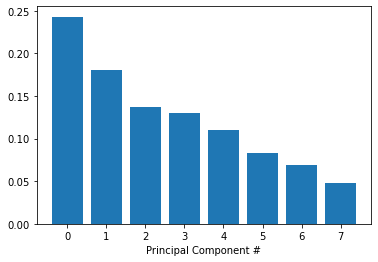

In [67]:
# plot the explained variance using a barplot
fig, ax = plt.subplots()
ax.bar(range(pca.n_components_),exp_variance)
ax.set_xlabel('Principal Component #')
plt.show()

## 5/ Visualisation plus poussée de l'ACP:
<p>😣 Malheureusement, il ne semble pas y avoir de coude clair dans ce tracé, ce qui signifie qu'il n'est pas simple de trouver le nombre de dimensions intrinsèques à l'aide de cette méthode. Au lieu de cela, nous pouvons examiner le graphique de la variance expliquée cumulative pour déterminer combien de caractéristiques sont nécessairesdisons, environ 90 % de la variance.</p>

In [89]:
# Import numpy
import numpy as np

# Calculate the cumulative explained variance
cum_exp_variance = np.cumsum(exp_variance)
cum_exp_variance

array([0.24297674, 0.4234199 , 0.55992299, 0.68986388, 0.80042636,
       0.88344881, 0.95268664, 1.        ])

AttributeError: 'list' object has no attribute 'y'

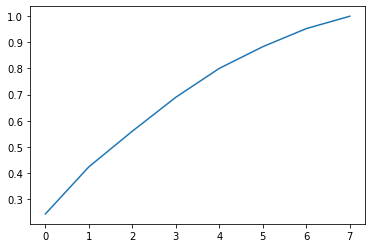

In [88]:
# Plot the cumulative explained variance and draw a dashed line at 0.90.
fig, ax = plt.subplots()
ax.plot(range(8),cum_exp_variance).y
 
ax.axhline(y=0.9, linestyle='--')
plt.show()

In [70]:
# choose the n_components where about 85% of our variance can be explained
n_components = 7

# Perform PCA with the chosen number of components and project data onto components
pca = PCA(n_components, random_state=10)
pca.fit(scaled_train_features)
pca_projection = pca.transform(scaled_train_features)

In [71]:
scaled_train_features.shape

(4802, 8)

In [72]:
pca_projection.shape

(4802, 7)

> Nous pouvons maintenant utiliser PCA de dimension inférieure des données pour classer les chansons en genres.

## 6/ Arbre de décision:

> Un arbre de décision est un outil d'aide à la décision représentant un ensemble de choix sous la forme graphique d'un arbre. Les différentes décisions possibles sont situées aux extrémités des branches, et sont atteintes en fonction de décisions prises à chaque étape


<center><img src="https://s3.amazonaws.com/assets.datacamp.com/production/project_449/img/simple_decision_tree.png" alt="Decision Tree Flow Chart Example" width="350px"></center>


* <span style="color:red"><b>Etape 1:</b></span> Diviser notre ensemble de données en sous-ensembles « train » et « test ».

In [73]:
# Import train_test_split function and Decision tree classifier
from sklearn.model_selection import train_test_split

# Split our data
train_features, test_features, train_labels, test_labels = train_test_split(pca_projection, labels, stratify = labels)

# Train our decision tree
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier(random_state = 10)
tree.fit(train_features, train_labels)


DecisionTreeClassifier(random_state=10)

* <span style="color:red"><b>Etape 2:</b></span> Prédiction des données à partir de l'arbre entraîner.

In [74]:
# Predict the labels for the test data
pred_labels_tree = tree.predict(test_features)

* Score de classification de précision.

In [75]:
from sklearn.metrics import accuracy_score
accuracy_score(test_labels, pred_labels_tree)

0.8726061615320566

<span style="color:orange"><b>L'ensemble d'étiquettes prédit pour un échantillon correspondre 80% à l'ensemble d'étiquettes correspondant dans test_labels.</b></span>

* Mais pourquoi il ne sont pas exact 🤔🤔??? 

In [76]:
labels.value_counts()

Rock       3892
Hip-Hop     910
Name: genre_top, dtype: int64

> Nos données sont déséquilibrées, donc ici la précision n'est pas vraiment une bonne mesure. Regardons la matrice de confusion.

In [77]:
from sklearn.metrics import confusion_matrix
confusion_matrix(test_labels, pred_labels_tree)

array([[134,  94],
       [ 59, 914]], dtype=int64)

> Il faut tester au moins quelques autres algorithmes et de trouver qui convient le mieux à nos données, et qui seront encore plus performants 

## 7/ Arbre de décision vs Régression logistique
Parfois, le plus simple est le meilleur, et nous allons donc commencer par appliquer la régression logistique . La régression logistique utilise ce qu'on appelle la fonction logistique pour calculer les chances qu'un point de données donné appartienne à une classe donnée.</br>

<center><img src="https://datascientest.com/wp-content/uploads/2020/11/illu_regression_blog-16-1024x562.png" alt="Decision Tree Flow Chart Example" width="350px"></center>


Une fois que nous avons les deux modèles, nous pouvons les comparer sur quelques mesures de performance, telles que le taux de faux positifs et de faux négatifs (ou combien de points sont classés de manière inexacte).

In [78]:
# Import LogisticRegression
from sklearn.linear_model import LogisticRegression

# Train our logistic regression and predict labels for the test set
logreg = LogisticRegression(random_state = 10)
logreg.fit(train_features, train_labels)
pred_labels_logit = logreg.predict(test_features)

* Créer le rapport de classification pour les deux modèles

In [79]:
from sklearn.metrics import classification_report
class_rep_tree = classification_report(test_labels, pred_labels_tree)
class_rep_log = classification_report(test_labels, pred_labels_logit)

print("Decision Tree: \n", class_rep_tree)
print("Logistic Regression: \n", class_rep_log)

Decision Tree: 
               precision    recall  f1-score   support

     Hip-Hop       0.69      0.59      0.64       228
        Rock       0.91      0.94      0.92       973

    accuracy                           0.87      1201
   macro avg       0.80      0.76      0.78      1201
weighted avg       0.87      0.87      0.87      1201

Logistic Regression: 
               precision    recall  f1-score   support

     Hip-Hop       0.85      0.51      0.64       228
        Rock       0.89      0.98      0.93       973

    accuracy                           0.89      1201
   macro avg       0.87      0.74      0.79      1201
weighted avg       0.89      0.89      0.88      1201



## 8/ Équilibrer nos données pour plus de performances :
Nos deux modèles fonctionnent de manière similaire, avec une précision moyenne de 87 % chacun.
En regardant notre rapport de classification, nous pouvons voir que les chansons rock sont assez bien classées, mais les chansons hip-hop sont classées à de manière disproportionnée.

In [80]:
# Subset only the hip-hop tracks, and then only the rock tracks
hop_only = echo_tracks.loc[echo_tracks['genre_top'] == 'Hip-Hop']
rock_only = echo_tracks.loc[echo_tracks['genre_top'] == 'Rock']
rock_only.head()

,track_id,genre_top,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence
0,153,Rock,0.988306,0.255661,0.979774,0.973006,0.121342,0.051740,90.241,0.034018
1,154,Rock,0.970135,0.352946,0.023852,0.957113,0.113261,0.032177,53.758,0.035632
2,155,Rock,0.981657,0.142249,0.912122,0.967294,0.363510,0.087527,91.912,0.034325
3,169,Rock,0.989141,0.225978,0.722835,0.263076,0.092371,0.053406,94.322,0.028347
4,170,Rock,0.886660,0.298518,0.744333,0.920950,0.139587,0.088781,97.880,0.073548


In [81]:
rock_only.shape, hop_only.shape

((3892, 10), (910, 10))

Echantillonnez les chansons rock pour qu'elles soient le même nombre qu'il y a des chansons hip-hop

In [82]:
rock_only = rock_only.sample(n= hop_only.shape[0])
rock_only.shape, hop_only.shape

((910, 10), (910, 10))

In [83]:
# concatenate the dataframes rock_only and hop_only
rock_hop_bal = pd.concat([rock_only, hop_only])
rock_hop_bal.shape

(1820, 10)

In [84]:
# The features, labels, and pca projection are created for the balanced dataframe
features = rock_hop_bal.drop(['genre_top', 'track_id'], axis=1) 
labels = rock_hop_bal['genre_top']
pca_projection = pca.fit_transform(scaler.fit_transform(features))

# Redefine the train and test set with the pca_projection from the balanced data
train_features, test_features, train_labels, test_labels = train_test_split(pca_projection,
                                                                            labels,
                                                                            stratify = labels,
                                                                            random_state=10)

##  L'équilibrage de notre ensemble de données améliore-t-il le biais du modèle ?
Nous avons maintenant équilibré notre ensemble de données, mais nous avons supprimé de nombreux points de données qui auraient pu être cruciaux pour l'entraînement de nos modèles. 
* Testons pour voir si l'équilibrage de nos données améliore le biais du modèle vers la classification « Rock » tout en conservant les performances globales de la classification.

In [85]:
# Train our decision tree on the balanced data
tree = DecisionTreeClassifier(random_state=10)
tree.fit(train_features, train_labels)
pred_labels_tree = tree.predict(test_features)

# Train our logistic regression on the balanced data
logreg = LogisticRegression(random_state = 10)
logreg.fit(train_features, train_labels)
pred_labels_logit = logreg.predict(test_features)

In [86]:
# Compare the models
print("Decision Tree: \n", classification_report(test_labels, pred_labels_tree))
print("Logistic Regression: \n", classification_report(test_labels, pred_labels_logit))

Decision Tree: 
               precision    recall  f1-score   support

     Hip-Hop       0.79      0.78      0.78       227
        Rock       0.78      0.79      0.79       228

    accuracy                           0.78       455
   macro avg       0.78      0.78      0.78       455
weighted avg       0.78      0.78      0.78       455

Logistic Regression: 
               precision    recall  f1-score   support

     Hip-Hop       0.87      0.79      0.83       227
        Rock       0.81      0.89      0.85       228

    accuracy                           0.84       455
   macro avg       0.84      0.84      0.84       455
weighted avg       0.84      0.84      0.84       455



<center><h1> <span style="color:red"> validation croisée pour évaluer nos modèles</span> </h1></center>
Succès! L'équilibrage de nos données a supprimé le biais en faveur de la classe la plus répandue. Pour avoir une bonne idée de la performance réelle de nos modèles, nous pouvons appliquer ce qu'on appelle la validation croisée (CV). Cette étape nous permet de comparer les modèles de façon plus rigoureuse

In [87]:
from sklearn.model_selection import KFold, cross_val_score

# Set up our K-fold cross-validation
kf = KFold(n_splits=10, random_state=10, shuffle=True)

tree = DecisionTreeClassifier(random_state=10)
logreg = LogisticRegression(random_state=10)

# Train our models using KFold cv
tree_score = cross_val_score(tree, pca_projection, labels, cv = kf)
logit_score = cross_val_score(logreg, pca_projection, labels, cv = kf)

# Print the mean of each array of scores
print("Decision Tree:", np.mean(tree_score),
      "Logistic Regression:", np.mean(logit_score))

Decision Tree: 0.810989010989011 Logistic Regression: 0.85


<div class="alert alert-block alert-danger"> <span style="color:#800000">
Nous pouvons voir ici que notre modèle de régression logistique simple a donné de meilleurs résultats que le modèle d'arbre de décision sur les données équilibrées. Nous pouvons essayer des modèles plus avancés comme Random Forest et SVM pour améliorer nos résultats.</span> </div>
